/tmp/ipython-input-2790730072.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Income"].fillna(df["Income"].median(), inplace=True)


Any remaining NaNs in X? 0
k=2: Inertia=17041.24, Silhouette=0.2415
k=5: Inertia=13505.44, Silhouette=0.1450
k=7: Inertia=12395.48, Silhouette=0.1327
k=9: Inertia=11536.16, Silhouette=0.1445


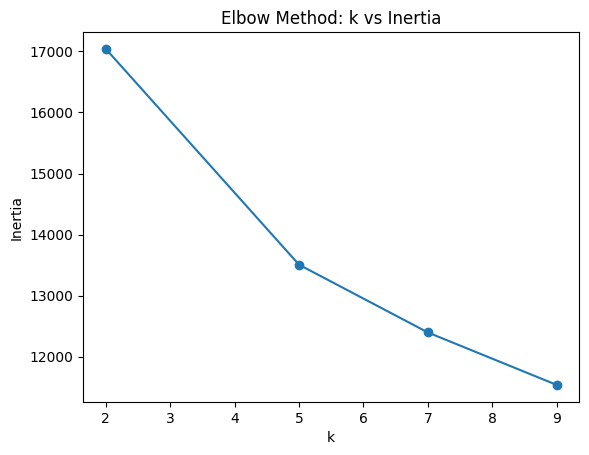

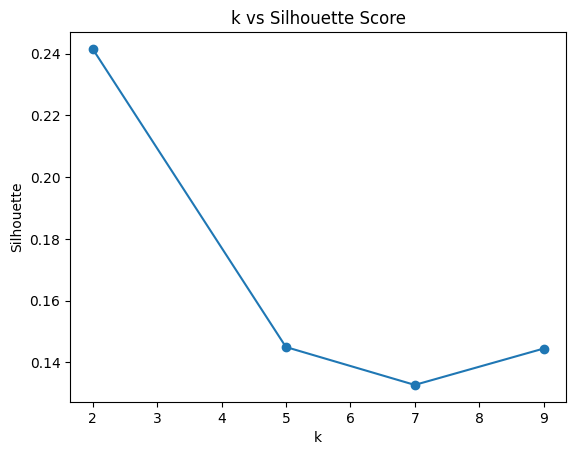

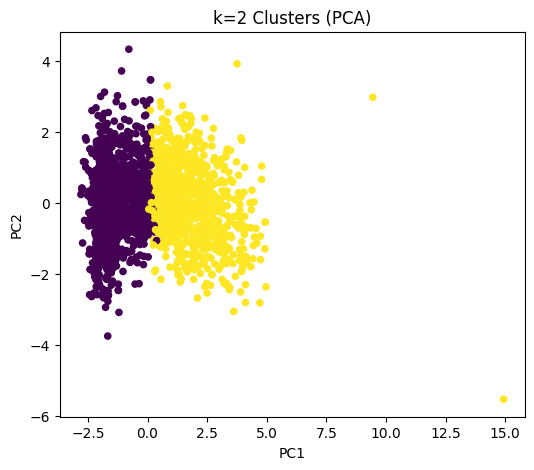

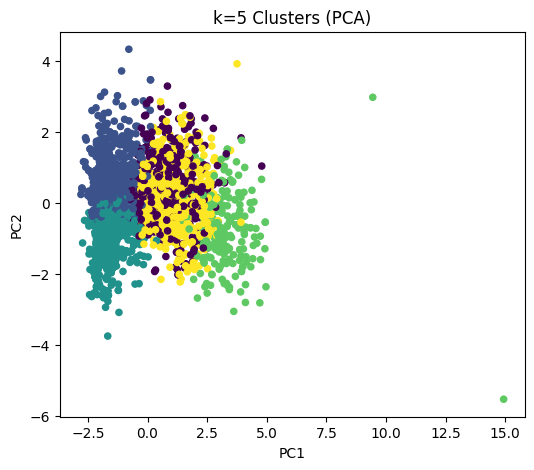

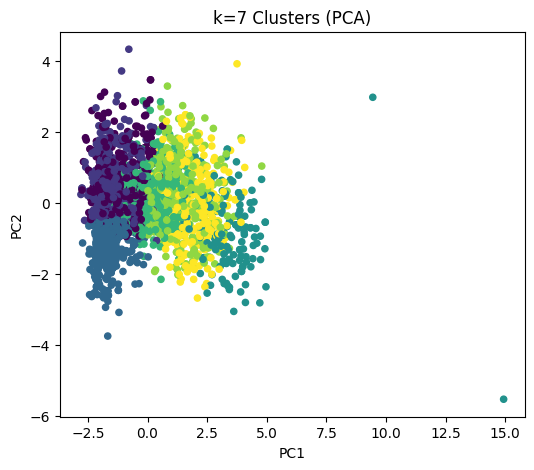

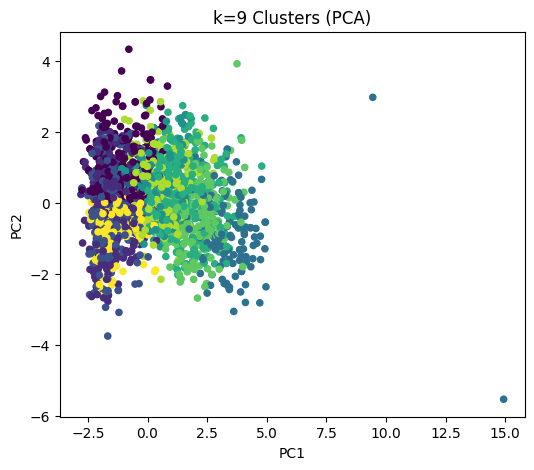

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- LOAD AND CLEAN ---
df = pd.read_csv('marketing_campaign.csv', sep='\t', dtype=str)

# Numeric columns
num_cols = [
    "Income", "Year_Birth", "Kidhome", "Teenhome", "Recency", "MntWines", "MntFruits",
    "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds",
    "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",
    "NumWebVisitsMonth", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "AcceptedCmp1", "AcceptedCmp2",
    "Complain", "Z_CostContact", "Z_Revenue", "Response"
]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Median fill for Income
df["Income"].fillna(df["Income"].median(), inplace=True)
df["Education"] = df["Education"].replace({'2n Cycle': 'Master'})
df["Marital_Status"] = df["Marital_Status"].replace({"Alone": "Single", "Absurd": "Other", "YOLO": "Other"})
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors='coerce')

# --- FEATURE ENGINEERING (EXACTLY as in your Power BI) ---
current_year = datetime.now().year
df["Age"] = current_year - df["Year_Birth"]
spending_cols = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
df["Total_Spending"] = df[spending_cols].sum(axis=1)
df["Total_Children"] = df["Kidhome"] + df["Teenhome"]
accept_cols = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]
df["Total_Accepted_Campaigns"] = df[accept_cols].sum(axis=1)
purchase_cols = ["NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]
df["Total_Purchases_Count"] = df[purchase_cols].sum(axis=1)
df["Avg_Spend_Per_Purchase"] = np.where(df["Total_Purchases_Count"] > 0,
                                        df["Total_Spending"]/df["Total_Purchases_Count"], 0)
df["Customer_Tenure"] = current_year - df["Dt_Customer"].dt.year.fillna(current_year).astype(int)

# Categorical encode
cat_features = ["Education", "Marital_Status"]
for c in cat_features:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

# Final clean (defensive): fill any possible remaining NaNs
df = df.fillna(0)

# --- CHOOSE CLUSTERING FEATURES ---
features = [
    'Income', 'Age', 'Total_Spending', 'Total_Children',
    'Total_Accepted_Campaigns', 'Total_Purchases_Count',
    'Avg_Spend_Per_Purchase', 'Customer_Tenure'
] + cat_features

X = df[features].values.astype(float)
X = StandardScaler().fit_transform(X)

print("Any remaining NaNs in X?", np.isnan(X).sum())  # Should be 0!

# --- K-MEANS FROM SCRATCH ---
def kmeans_scratch(X, k, max_iter=100):
    rng = np.random.RandomState(42)
    idx = rng.choice(X.shape[0], k, replace=False)
    centroids = X[idx]
    for it in range(max_iter):
        dists = np.linalg.norm(X[:, None] - centroids, axis=2)
        labels = dists.argmin(axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                                  for i in range(k)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    inertia = ((X - centroids[labels])**2).sum()
    return labels, centroids, inertia

Ks = [2, 5, 7, 9]
inertias = []
silhouettes = []
all_labels = {}

for k in Ks:
    labels, centroids, inertia = kmeans_scratch(X, k)
    all_labels[k] = labels
    inertias.append(inertia)
    silhouette = silhouette_score(X, labels) if k > 1 else np.nan
    silhouettes.append(silhouette)
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette={silhouette:.4f}")

# --- ELBOW & SILHOUETTE PLOTS ---
plt.figure()
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow Method: k vs Inertia")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(Ks, silhouettes, marker='o')
plt.title("k vs Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

# --- 2D CLUSTER VISUALIZATION ---
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)
for k in Ks:
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], c=all_labels[k], cmap='viridis', s=20)
    plt.title(f'k={k} Clusters (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
